/home/dronelab/delaunay_rasterization
Vertex Torch Grad: [[ -227.75093   -721.47327    -25.870401]
 [ 2738.965     5054.6675   -2610.9426  ]
 [ 1350.7738    2672.4653    1581.2052  ]
 [  505.80035    643.484    -4407.2925  ]]
Vertex Jax Grad: [[ -981.65875 -2231.5984    729.7817 ]
 [    0.          0.          0.     ]
 [    0.          0.          0.     ]
 [    0.          0.          0.     ]]
Max value torch: 0.3132099211215973
Max value jax: 0.2656007409095764
Mean Error: 9.572430280968547e-05
Max Error: 0.06933152675628662
tensor([[ 0.0000,  1.0000, -0.0081]], device='cuda:0',
       grad_fn=<VertexShaderBackward>)


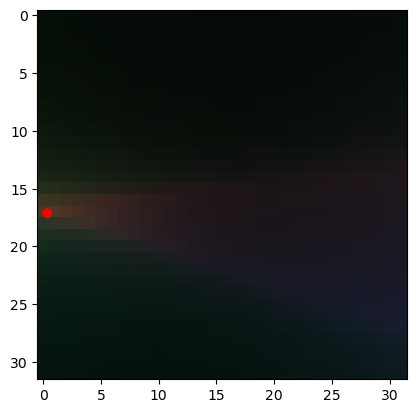

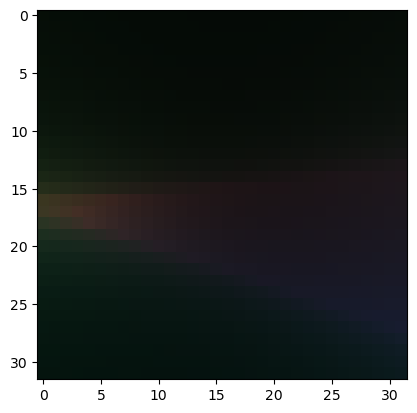

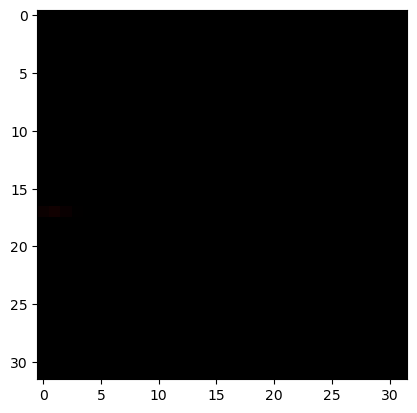

In [ ]:
import os
VERSION = 9
if VERSION is not None:
    os.environ["CC"] = f"/usr/bin/gcc-{VERSION}"
    os.environ["CXX"] = f"/usr/bin/g++-{VERSION}"
from pathlib import Path
import sys
sys.path.append(str(Path(os.path.abspath('')).parent))
print(str(Path(os.path.abspath('')).parent))

from utils.compare_quad import test_tetrahedra_rendering, setup_camera
from delaunay_rasterization.internal.tile_shader_slang import point2image
import torch
import matplotlib.pyplot as plt
import numpy as np
import random

# Create sample tetrahedra
torch.manual_seed(0)
N = 4
vertices = (torch.rand((N, 3)).cuda() * 2 - 1) * 100
indices = torch.tensor([[0, 1, 2, 3]]).int().cuda()

vertex_color = torch.tensor([
        [1.0, 0.0, 0.0],
        [0.0, 1.0, 0.0],
        [0.0, 0.0, 1.0],
        [0.5, 0.0, 0.5],
        # [0.0, 0.0, 1.0],
        # [0.0, 0.0, 1.0],
        # [0.0, 0.0, 1.0],
        # [0.0, 0.0, 1.0],
]).cuda()
# vertex_color = torch.ones_like(vertex_color)
tet_density = torch.tensor([[10.0]]).cuda()


# Generate random barycentric coordinates that sum to 1
barycentric = torch.rand(4).cuda()
barycentric = barycentric / barycentric.sum()

# Use barycentric coordinates to get a point inside the tetrahedron
origin = vertices[indices[0]].T @ barycentric  # Shape: (3,)

# Update viewmat with new origin
viewmat = torch.eye(4)
viewmat[:3, 3] = origin  # Set translation to sampled point
viewmat = torch.linalg.inv(viewmat)
vertices = torch.tensor([[-0.0954798982, -0.0576470010,  0.0907066390],
        [-0.0794274211, -0.0494611152,  0.0444854014],
        [-0.0524959937,  0.0647660419,  0.0939735770],
        [-0.0065456270,  0.0679433569,  0.0750745535]], device='cuda:0')
viewmat = torch.tensor([[-0.8002946973, -0.5985016227,  0.0363887995, -0.0098749101],
        [-0.4739684165,  0.6686108708,  0.5729864836, -0.0947880447],
        [ 0.3672632575, -0.4413108826,  0.8187565804,  0.6489951611],
        [ 0.0000000000,  0.0000000000,  0.0000000000,  1.0000000000]],
       device='cuda:0')
vertices = torch.tensor([[ 0.2430675477, -0.3873929977,  0.3781652451],
        [ 0.2899414003, -0.1144087315,  0.2279857695],
        [-0.3941484988,  0.2187604010,  0.3265861571],
        [-0.3360970914,  0.1398774236,  0.1634573936]], device='cuda:0')
viewmat = torch.tensor([[ 9.2208576202e-01, -3.7686905265e-01,  8.7907373905e-02,
          8.3750230260e-05],
        [ 3.0987361446e-02,  2.9833433032e-01,  9.5395827293e-01,
         -2.2361640632e-01],
        [ 3.8574317098e-01,  8.7690722942e-01, -2.8676798940e-01,
          1.9718817472e+00],
        [ 2.1461694644e-09, -2.4329395387e-08, -3.2908822334e-09,
          1.0000000000e+00]], device='cuda:0')
# vertices = torch.tensor([[-0.3819195926, -0.2305880040,  0.3628265560],
#         [-0.3177096844, -0.1978444606,  0.1779416054],
#         [-0.2099839747,  0.2590641677,  0.3758943081],
#         [-0.0261825081,  0.2717734277,  0.3002982140]], device='cuda:0')
# viewmat = torch.tensor([[ 8.0029475689e-01,  5.9850162268e-01, -3.6388747394e-02,
#           3.9499610662e-02],
#         [-4.7396835685e-01,  6.6861087084e-01,  5.7298648357e-01,
#          -3.7915235758e-01],
#         [-3.6726331711e-01,  4.4131094217e-01, -8.1875652075e-01,
#           1.0243387222e+00],
#         [-1.3238860674e-08, -6.2472373941e-09,  2.1942579309e-08,
#           1.0000000000e+00]], device='cuda:0')
# vertices = torch.tensor([[ 0.2430675477, -0.3873929977,  0.3781652451],
#         [ 0.2899414003, -0.1144087315,  0.2279857695],
#         [-0.3941484988,  0.2187604010,  0.3265861571],
#         [-0.3360970914,  0.1398774236,  0.1634573936]], device='cuda:0')
# viewmat = torch.tensor([[ 9.2208570242e-01, -3.7686908245e-01,  8.7907396257e-02,
#           8.3774328232e-05],
#         [ 3.0987352133e-02,  2.9833433032e-01,  9.5395833254e-01,
#          -2.2361648083e-01],
#         [ 3.8574314117e-01,  8.7690728903e-01, -2.8676798940e-01,
#           7.0029509068e-01],
#         [ 0.0000000000e+00,  0.0000000000e+00,  0.0000000000e+00,
#           1.0000000000e+00]], device='cuda:0')
# vertices = torch.tensor([[ 0.2430675477, -0.3873929977,  0.3781652451],
#         [ 0.2899414003, -0.1144087315,  0.2279857695],
#         [-0.3941484988,  0.2187604010,  0.3265861571],
#         [-0.3360970914,  0.1398774236,  0.1634573936]], device='cuda:0')
# viewmat = torch.tensor([[-0.4876191318, -0.8475935459, -0.2093149424, -0.0044252351],
#         [-0.8258575201,  0.5255668759, -0.2043008804,  0.1754622161],
#         [ 0.2831731141,  0.0732432902, -0.9562679529,  0.2541924715],
#         [ 0.0000000000,  0.0000000000,  0.0000000000,  1.0000000000]],
#        device='cuda:0')
# vertices = torch.tensor([[ 0.2430675477, -0.3873929977,  0.3781652451],
#         [ 0.2899414003, -0.1144087315,  0.2279857695],
#         [-0.3941484988,  0.2187604010,  0.3265861571],
#         [-0.3360970914,  0.1398774236,  0.1634573936]], device='cuda:0')
# viewmat = torch.tensor([[-0.7677200437,  0.1756590605,  0.6162384152, -0.0968539640],
#         [ 0.3055213988,  0.9456868172,  0.1110551804,  0.0558680296],
#         [-0.5632607341,  0.2735333145, -0.7796902657,  0.2879556417],
#         [ 0.0000000000,  0.0000000000,  0.0000000000,  1.0000000000]],
#        device='cuda:0')

# Run test
results = test_tetrahedra_rendering(
    vertices.cuda(), indices, vertex_color, tet_density, viewmat,
    height=32, width=32, tile_size=8, fov=140, tmin=0)
#     height=32, width=32, tile_size=8, fov=140, tmin=0)
    # height=8, width=8)
viewmat, projection_matrix, cam_pos, fovy, fovx, fx, fy = setup_camera(32, 32, 140, viewmat)
image_points = point2image(vertices.cuda(), viewmat.cuda(), projection_matrix.cuda(), cam_pos.cuda()).cpu().numpy()

plt.scatter(image_points[:, 0], image_points[:, 1], c=vertex_color.cpu().numpy())

# print(f"Num gt: {(results['torch_image'] > 0).sum()//3} vs Pred: {results['tet_area']}")
# print(results['rect_tile_space'])
print(f"Vertex Torch Grad: {results['torch_vertex_grad']}")
print(f"Vertex Jax Grad: {results['jax_vertex_grad']}")
# print(f"RGBS Torch Grad: {results['torch_rgbs_grad']}")
# print(f"RGBS Jax Grad: {results['jax_rgbs_grad']}")
print(f"Max value torch: {results['torch_image'].max()}")
print(f"Max value jax: {results['jax_image'].max()}")
print(f"Mean Error: {results['mean_error']}")
print(f"Max Error: {results['max_error']}")
print(results['torch_extras']['viewspace_points'])
plt.imshow(results['torch_image'])
plt.show()
plt.imshow(results['jax_image'][..., :3])
plt.show()
plt.imshow(np.abs(results['jax_image'][..., :3] - results['torch_image']))
plt.show()

In [2]:
from jaxutil import tetra_quad
import jax.numpy as jnp
cam_pos = jnp.linalg.inv(viewmat.cpu().numpy())[:3, 3]
print(vertices, indices)
tetra_quad.point_in_tetrahedron(vertices.cpu().numpy(), indices.cpu().numpy()[0], cam_pos)

tensor([[ 0.2431, -0.3874,  0.3782],
        [ 0.2899, -0.1144,  0.2280],
        [-0.3941,  0.2188,  0.3266],
        [-0.3361,  0.1399,  0.1635]], device='cuda:0') tensor([[0, 1, 2, 3]], device='cuda:0', dtype=torch.int32)


Array(False, dtype=bool)

In [3]:

print(vertices, viewmat)
print(viewmat @ torch.cat([vertices.T, torch.ones_like(vertices.T[:1, :])], dim=0))

tensor([[ 0.2431, -0.3874,  0.3782],
        [ 0.2899, -0.1144,  0.2280],
        [-0.3941,  0.2188,  0.3266],
        [-0.3361,  0.1399,  0.1635]], device='cuda:0') tensor([[-9.2209e-01,  3.7687e-01, -8.7907e-02, -8.3758e-05],
        [ 3.0987e-02,  2.9833e-01,  9.5396e-01, -2.2362e-01],
        [-3.8574e-01, -8.7691e-01,  2.8677e-01, -5.3862e-02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]], device='cuda:0')
tensor([[-4.0345e-01, -3.3059e-01,  4.1709e-01,  3.4817e-01],
        [ 2.9097e-02, -3.1275e-02,  1.4098e-01, -3.6369e-02],
        [ 3.0053e-01,  1.4901e-08, -2.9802e-08, -7.4506e-09],
        [ 1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00]], device='cuda:0')


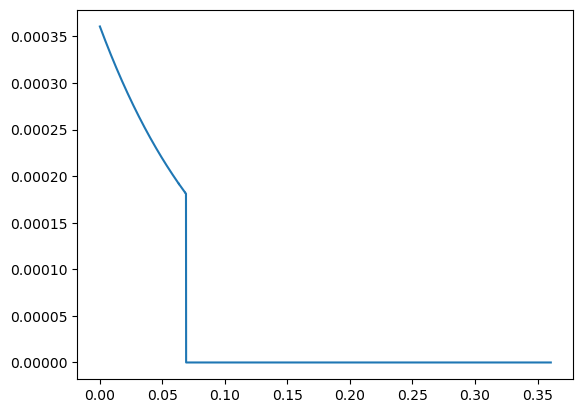

[3.6067187e-05 7.2134375e-05 1.0820156e-04 ... 3.6056367e-01 3.6059976e-01
 3.6063582e-01]


In [4]:

i, j = 30, 5
plt.plot(results['extras']['tdist'][i, j][1:], results['extras']['weights'][i, j][0])
plt.show()
print(results['extras']['tdist'][i, j][1:])